# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных
Признаки

DateCrawled — дата скачивания анкеты из базы
VehicleType — тип автомобильного кузова
RegistrationYear — год регистрации автомобиля
Gearbox — тип коробки передач
Power — мощность (л. с.)
Model — модель автомобиля
Kilometer — пробег (км)
RegistrationMonth — месяц регистрации автомобиля
FuelType — тип топлива
Brand — марка автомобиля
NotRepaired — была машина в ремонте или нет
DateCreated — дата создания анкеты
NumberOfPictures — количество фотографий автомобиля
PostalCode — почтовый индекс владельца анкеты (пользователя)
LastSeen — дата последней активности пользователя
Целевой признак

Price — цена (евро)

## Подготовка данных

In [1]:
!pip install lightgbm -q

In [2]:
! pip install phik -q

In [3]:
! pip install -Uq scikit-learn

In [4]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 6), dpi=80);
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
import time

<Figure size 1440x480 with 0 Axes>

In [5]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Переведем названия столбцов в общепринятый формат

In [6]:
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
      'last_seen']
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Начнем с удаления неинформативных признаков

Рассмотрим дату создания анкеты и последнюю активность пользователя

In [8]:
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%Y-%m-%d %H:%M:%S')
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%d %H:%M:%S')
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%Y-%m-%d %H:%M:%S')

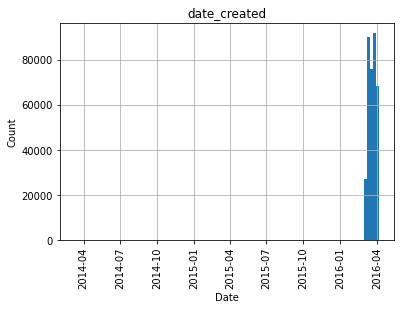

In [9]:
df['date_created'].hist(bins=100)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('date_created')
plt.xticks(rotation=90)
plt.show()

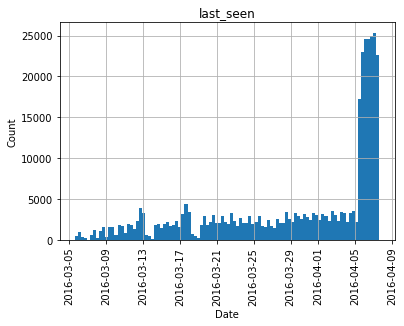

In [10]:
df['last_seen'].hist(bins=100)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('last_seen')
plt.xticks(rotation=90)
plt.show()

Из гистограмм видно, что большинство анкет создано в марте-апреле 2016 года, но есть небольшое количесвто анкет, созданных в  2014-2016 гг. Можно было бы предположить, что информация в этих анкетах потеряла свою актуальность. Но так как дата последней активности пользователей находится в диапазоне март-апрель 2016 года, все анкеты должны быть одинаково актуальны. Исключим эти признаки из выборки, как не несущие полезной информации. Также на стоимость автомобиля не могут влиять дата выгрузки анкеты, месяц регистрации автомобиля, почтовый индекс владельца анкеты

In [11]:
df = df.drop(['date_created', 'last_seen', 'registration_month', 'postal_code'], axis=1)

Text(0.5, 1.0, 'price')

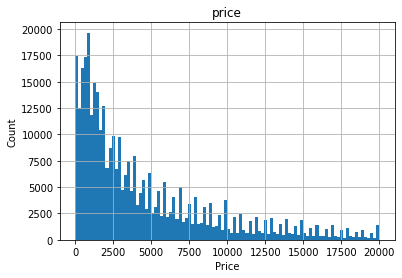

In [12]:
df.price.hist(bins=100);
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('price')

Объявления, у которых отсутствует целевой признак, или он слишком маленький, не подходят для обучения модели. Исключим эти объекты из выборки.

In [13]:
df = df.query('price>500')

Заменим пропуске в столбцах с типом кузова, коробкой передач, моделью, типом топлива на dummy-значение 'unknown':

In [14]:
df[['vehicle_type', 'gearbox', 'model', 'fuel_type']] = df[['vehicle_type', 'gearbox', 'model', 'fuel_type']].fillna('unknown')

Ремонтированные автомобили

In [15]:
df.not_repaired.value_counts(normalize=True)

no     0.905463
yes    0.094537
Name: not_repaired, dtype: float64

Среди тех объявлений, где указано, ремонтировалась ли машина, всего лишь 12% автомобилей не были в ремонте. Среди объявлений, где это этот признак не указан, вероятно, такое же превалирование ремонтированных машин. Заменим пропуски на 'no'.

In [16]:
df.not_repaired = df.not_repaired.fillna('no')

Год регистрации

Text(0.5, 1.0, 'registration_year')

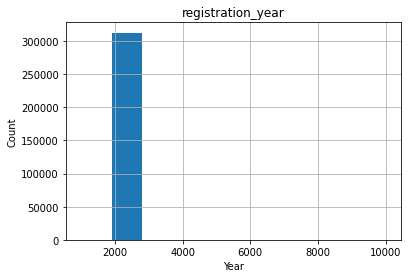

In [17]:
df['registration_year'].hist();
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('registration_year')

Видно, что значения года регистрации находятся в диапазоне от 0 до 10000, что указывает на наличие некорректных значений

Text(0.5, 1.0, 'registration_year')

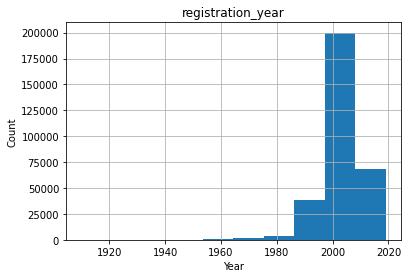

In [18]:
df[(df['registration_year'] < 2030) & (df['registration_year'] > 1900)]['registration_year'].hist();plt.xlabel('Date')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('registration_year')

Предположим, что в объявлениях действительно есть раритетные автомобили до 1940 года выпуска. Дату в объявлениях раньше 1940 или позже 2020 заменим на dummy-значение 0.

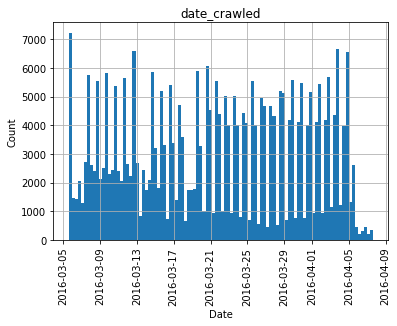

In [19]:
df['date_crawled'].hist(bins=100)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('date_crawled')
plt.xticks(rotation=90)
plt.show()

После проверки на актуальность базы данных мы узнали, что дата последнего скачивания была 5 апереля 2016 года

In [20]:
def change_date(row):
    if (row['registration_year'] < 1940) or (row['registration_year'] > 2017):
        return 0
    else:
        return row['registration_year']

In [21]:
df['registration_year'] = df.apply(change_date, axis=1)

Количество фотографий

In [22]:
df.number_of_pictures.value_counts()

0    312645
Name: number_of_pictures, dtype: int64

У каждого объявления указано нулевое количество фотографий. Удалим этот признак как неинформативный

In [23]:
df = df.drop(['number_of_pictures'], axis=1)

Мощность

Text(0.5, 1.0, 'power')

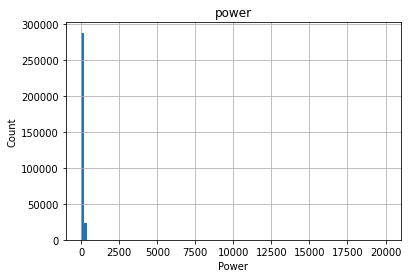

In [24]:
df.power.hist(bins=100);
plt.xlabel('Power')
plt.ylabel('Count')
plt.title('power')

Видно, что имеется большое количество выбросов.

In [25]:
print('0.1% наибольших значений мощности принимает значения выше', df.power.quantile(.999))
df[df['power'] > df.power.quantile(.999)]

0.1% наибольших значений мощности принимает значения выше 600.0


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
1816,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
4060,2016-04-03 20:31:00,3100,sedan,2005,manual,953,colt,150000,gasoline,mitsubishi,no
6296,2016-03-31 23:50:47,599,small,2002,manual,603,matiz,5000,petrol,chevrolet,yes
6504,2016-03-14 15:54:34,3000,small,2009,manual,771,punto,125000,petrol,fiat,no
6637,2016-03-31 19:48:22,600,small,1996,manual,603,corsa,150000,petrol,opel,yes
...,...,...,...,...,...,...,...,...,...,...,...
348668,2016-03-05 17:53:09,1000,wagon,1996,manual,2598,a6,150000,unknown,audi,no
348883,2016-03-13 11:51:57,7500,sedan,2011,manual,1548,scenic,90000,petrol,renault,no
351947,2016-03-07 21:36:19,1500,bus,2001,manual,1001,zafira,5000,gasoline,opel,no
353493,2016-04-02 20:54:21,12500,unknown,2017,manual,2000,other,60000,gasoline,chrysler,no


Заменим выбросы, находящиеся в диапазоне выше 0.999 квантили, и нулевые значения на медианное значение

In [26]:
power_median = df.power.median()
power_quantile = df.power.quantile(.999)

In [27]:
def change_power(row):
    if (row['power'] > power_quantile) or (row['power'] == 0):
        return power_median
    else:
        return row['power']

In [28]:
df['power'] = df.apply(change_power, axis=1)

Text(0.5, 1.0, 'power')

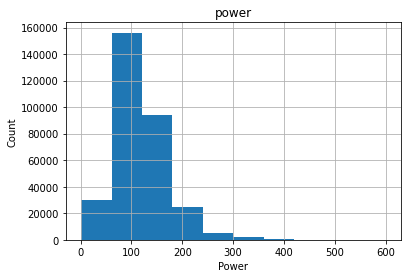

In [29]:
df.power.hist();
plt.xlabel('Power')
plt.ylabel('Count')
plt.title('power')

Теперь заменим тип данных на целочисленные

In [30]:
df['power'] = df['power'].astype(int)

Датафрейм готов для дальнейшего обучения моделей.

In [31]:
df.duplicated().sum()
df=df.drop_duplicates()
df.duplicated().sum()

0

In [32]:
df = df.drop(['date_crawled'], axis=1)

## Обучение моделей

Линейная регрессия

In [33]:
num_columns = ['power', 'kilometer']
ohe_columns=['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']


ohe_pipe_train = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=' ')),  # Заменяем пробелы на константу
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

num_pipe_train = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Заменяем пропуски медианным значением
    ('scaler', StandardScaler())
])

train_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe_train, ohe_columns),
    ('num', num_pipe_train, num_columns)
],  remainder='passthrough')

In [34]:
train_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=' ',
                                                                strategy='constant')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['vehicle_type', 'gearbox', 'model',
                                  'fuel_type', 'brand', 'not_repaired']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['power', 'kilometer'])])

Поделим данные на обучающую и тестовую выборки в отношении 4:1.

In [35]:
features = df.drop('price', axis=1)
target = df['price']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.2, random_state=1)

Масштабируем численные признаки и кодируем категориальные

In [36]:
%%time
fit_time_start = time.time()
RANDOM_STATE = 42
def rmse(true, pred):
    return sqrt(mean_squared_error(true, pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

param_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), 'passthrough']  
    }
]

# Создаем пайплайн
pipe_final = Pipeline([
    ('preprocessor', train_preprocessor),
    ('models', LinearRegression())
])

# Определяем метрику SMAPE

# Инициализируем поиск по сетке
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=rmse_scorer,  
    n_jobs=1,
    error_score='raise'
)

# Запускаем поиск по сетке
grid_search.fit(features_train, target_train)
fit_time_end = time.time()

best_index = np.argmax(grid_search.cv_results_['mean_test_score'])
best_score = -grid_search.cv_results_['mean_test_score'][best_index]
best_params = grid_search.cv_results_['params'][best_index]
print(f"Лучший результат RMSE: {best_score:.2f}")
print(f"Лучшие параметры: {best_params}")

best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(features_test)
rmse_linear = rmse(target_test, y_test_pred)
print('\nМетрика RMSE на тестовой выборке для лучшей модели:', rmse_linear)
predict_time_end = time.time()

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Лучший результат RMSE: 2900.33
Лучшие параметры: {'models': LinearRegression(), 'preprocessor__num': StandardScaler()}

Метрика RMSE на тестовой выборке для лучшей модели: 2887.794053996541
CPU times: user 22.4 s, sys: 16.7 s, total: 39 s
Wall time: 39.1 s


In [37]:
linear_fit_time = fit_time_end - fit_time_start
linear_pred_time = predict_time_end - fit_time_end

CatBoost

Для модели CatBoost необязательно перобразовывать категориальные признаки. Поделим исходный датафрейм на обучающую и тестовую выборки без преобразования категориальных признаков

In [38]:
features_cb = df.drop('price', axis=1)
target_cb = df['price']

features_cb_train, features_cb_test, target_cb_train, target_cb_test = train_test_split(
    features_cb, target_cb, test_size=.2, random_state=1)

cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

In [39]:
%%time
model_cb = CatBoostRegressor(loss_function='RMSE', random_state=1, verbose=0)
grid_cb = {'iterations': [10, 50, 100],
        'learning_rate': [0.03, 0.1],
        'depth': [1, 10, 15]}


train_cb = Pool(features_cb_train, target_cb_train, cat_features=cat_features) 

fit_time_start = time.time()
model_cb.grid_search(grid_cb, train_cb, verbose=0)
fit_time_end = time.time()
rmse_cb = rmse(target_cb_test, model_cb.predict(features_cb_test))
predict_time_end = time.time()
print('RMSE работы CatBoost на тестовой выборке:', rmse_cb)


bestTest = 5566.088009
bestIteration = 9


bestTest = 4105.913144
bestIteration = 9


bestTest = 3700.849555
bestIteration = 49


bestTest = 2845.243195
bestIteration = 49


bestTest = 3183.600339
bestIteration = 99


bestTest = 2516.176111
bestIteration = 99


bestTest = 5239.739354
bestIteration = 9


bestTest = 3232.478468
bestIteration = 9


bestTest = 2643.059611
bestIteration = 49


bestTest = 1845.627004
bestIteration = 49


bestTest = 1989.433778
bestIteration = 99


bestTest = 1759.204696
bestIteration = 99


bestTest = 5224.077678
bestIteration = 9


bestTest = 3191.911462
bestIteration = 9


bestTest = 2596.129685
bestIteration = 49


bestTest = 1755.631196
bestIteration = 49


bestTest = 1901.413943
bestIteration = 99


bestTest = 1687.636864
bestIteration = 99

Training on fold [0/3]

bestTest = 1679.718365
bestIteration = 99

Training on fold [1/3]

bestTest = 1702.497025
bestIteration = 99

Training on fold [2/3]

bestTest = 1694.044854
bestIteration = 99

RMSE работы C

In [40]:
cb_fit_time = fit_time_end - fit_time_start
cb_pred_time = predict_time_end - fit_time_end

LightGBM

Для работы модели LightGBM нужно преобразовать тип данных категориальных признаков

In [41]:
features_cb_train[cat_features] = features_cb_train[cat_features].astype('category')
features_cb_test[cat_features] = features_cb_test[cat_features].astype('category')

In [42]:
%%time
lgb_model = lgb.LGBMRegressor(random_state=1)
parametrs = {'n_estimators': [10, 50, 100],
             'learning_rate': [0.03, 0.1],
             'max_depth': [1, 10, 15],}
grid_lgb = GridSearchCV(lgb_model, param_grid=parametrs, cv=5, scoring=rmse_scorer)
fit_time_start = time.time()
grid_lgb.fit(features_cb_train, target_cb_train)
fit_time_end = time.time()
rmse_lgb = rmse(target_cb_test, grid_lgb.best_estimator_.predict(features_cb_test))
predict_time_end = time.time()

print('RMSE работы модели LightGBM на тестовой выборке:', rmse_lgb)
print('Максимальная глубина дерева наилучшей модели:', grid_lgb.best_params_['max_depth'])
print('Количество деревьев в наилучшей модели:', grid_lgb.best_params_['n_estimators'])
print('Коэффициент скорости обучения в наилучшей модели:', grid_lgb.best_params_['learning_rate'])

/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__

RMSE работы модели LightGBM на тестовой выборке: 1694.5782503403873
Максимальная глубина дерева наилучшей модели: 10
Количество деревьев в наилучшей модели: 100
Коэффициент скорости обучения в наилучшей модели: 0.1
CPU times: user 29min 2s, sys: 7.95 s, total: 29min 10s
Wall time: 29min 13s


In [43]:
lgb_fit_time = fit_time_end - fit_time_start
lgb_pred_time = predict_time_end - fit_time_end

## Анализ моделей

In [44]:
results = pd.DataFrame({'Models':['Linear Regression', 'CatBoost', 'LightGBM'],
                       'RMSE': [rmse_linear, rmse_cb, rmse_lgb],
                       'Fit time': [linear_fit_time, cb_fit_time, lgb_fit_time],
                       'Predict time': [linear_pred_time, cb_pred_time, lgb_pred_time]})
display(results)

,Models,RMSE,Fit time,Predict time
0,Linear Regression,2887.794054,38.855654,0.232298
1,CatBoost,1672.680590,473.768507,0.125736
2,LightGBM,1694.578250,1752.807477,0.792414


Анализ работы моделей показал, что при схожих гиперпараметрах наибольшая точность у моделей градиентного бустинга (CatBoost, LightGBM). При этом модели градиентного бустинга обучаются весьма быстро, а скорость обучение LightGBM выше скорости обучения CatBoost в 1,5 раза. Наивысшая скорость обучения у модели линейной регрессии - менее минуты, но такая скорость компенсируется низкой точностью прогнозов.